## Results of the 3-means experiment

In [24]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
from bigdatavqa.postexecution import get_k_means_accumulative_cost
import random
import matplotlib.pyplot as plt

In [39]:
# Load cluster centres and coreset data
cluster_df = pd.read_pickle('../paper_results/data/3means/3means_cluster_centers_12_coreset.pkl')
coreset_df = pd.read_csv('../data/12_coreset.csv', encoding='ISO-8859-1')

### VQE costs

In [40]:
coreset_vectors = pd.DataFrame.to_numpy(coreset_df[['X', 'Y']])
weight_vectors = pd.Series.to_numpy(coreset_df['weights'])
cluster_vectors = pd.DataFrame.to_numpy(cluster_df)

non_weighted_cost = get_k_means_accumulative_cost(3, cluster_vectors, coreset_vectors)
weighted_cost = get_k_means_accumulative_cost(3, cluster_vectors, coreset_vectors, weight_vectors)

VQE_cost_value = weighted_cost

Non-weighted cost: 46.43718493113637
Weighted cost: 4824.608463984105


### Kmeans costs

In [12]:
kmeans_unweighted = KMeans(init="k-means++", n_clusters=3, random_state=0).fit(coreset_vectors)
skl_unweighted_cost = get_k_means_accumulative_cost(3, kmeans_unweighted.cluster_centers_, coreset_vectors)
print('Scikit learn unweighted cost:', skl_unweighted_cost)

kmeans_weighted = KMeans(init="k-means++", n_clusters=3, random_state=0).fit(coreset_vectors, sample_weight=weight_vectors)
skl_weighted_cost = get_k_means_accumulative_cost(3, kmeans_weighted.cluster_centers_, coreset_vectors, weight_vectors)
print('Scikit learn weighted cost:', skl_weighted_cost)

kmeans_cost_value = skl_weighted_cost

Scikit learn unweighted cost: 41.266189742121156
Scikit learn weighted cost: 4200.602651251721


/home/yogi/.pyenv/versions/3.9.0/envs/VQA2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yogi/.pyenv/versions/3.9.0/envs/VQA2/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Brute force costs

In [14]:
# Load the 3-partitions of a set of 12
partitions = pd.read_csv('../paper_results/data/3means/3-partitions_maxcut.txt', header=None)
partitions_array = pd.DataFrame(partitions.values.reshape(-1, 3), columns=['S1', 'S2', 'S3']).to_numpy()
data = [list(map(lambda x: x.split(" "), y)) for y in partitions_array]

In [16]:
# Helper function
def brute_force_cost(coreset, weights, partition):
    coreset_partition = [[], [], []]
    weight_partition = [[], [], []]
    cluster_centres = np.empty((len(partition), 2))
    for i, subset in enumerate(partition):
        for index in subset:
            coreset_partition[i].append(coreset[int(index) - 1])
            weight_partition[i].append(weights[int(index) - 1])


    for i in range(len(partition)):
         cluster_centres[i] = np.average(coreset_partition[i], axis=0, weights=weight_partition[i])
        
    
    return get_k_means_accumulative_cost(3, cluster_centres, coreset, weights)

lowest_cost = np.inf
for partition in data:
    current_cost = brute_force_cost(coreset_vectors, weight_vectors, partition)
    if current_cost < lowest_cost:
        lowest_cost = current_cost

print(lowest_cost)

brute_force_cost_value = lowest_cost

### Random cluster costs

In [35]:
def get_random_cluster_centers(
    coreset_vectors,
    coreset_weights,
    cluster_size
):
    s1, s2, s3 = [], [], []
    for i in range(len(coreset_vectors)):
        set = random.randint(0, 2)
        if set == 0:
            s1.append(i)
        elif set == 1:
            s2.append(i)
        else:
            s3.append(i)

    partition = [s1, s2, s3]


    clusters_centers = np.array([np.zeros(cluster_size)] * 3)

    W = np.sum(coreset_weights) / 3
    # Compute cluster centres

    for i in range(len(partition)):
        for vertex in partition[i]:
            weight = coreset_weights[int(vertex / 2)] * coreset_vectors[int(vertex / 2)]
            clusters_centers[i] += weight * (1 / W)

    return clusters_centers

random_cluster_centers = get_random_cluster_centers(coreset_vectors, weight_vectors, 2)
random_cluster_cost_value = get_k_means_accumulative_cost(3, random_cluster_centers, coreset_vectors, weight_vectors)

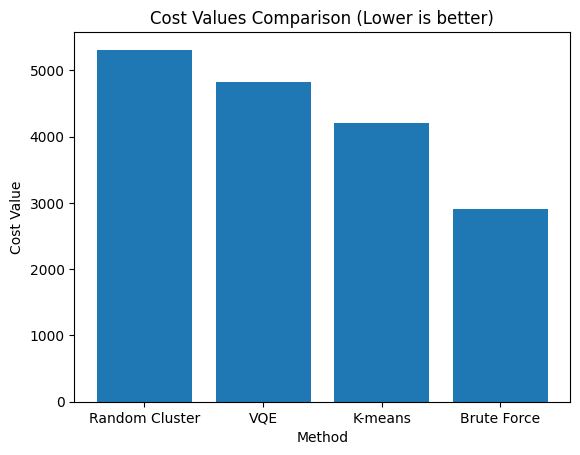

In [49]:
# Define the cost values
cost_values = [random_cluster_cost_value, VQE_cost_value, kmeans_cost_value, brute_force_cost_value]

# Define the labels for the x-axis
labels = ['Random Cluster','VQE', 'K-means', 'Brute Force']

# Create the bar chart
plt.bar(labels, cost_values)

# Add labels and title
plt.xlabel('Method')
plt.ylabel('Cost Value')
plt.title('Cost Values Comparison (Lower is better)')

# Display the chart
plt.show()
